# Baseline метода

In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

Text(0.5, 1.0, 'AQI')

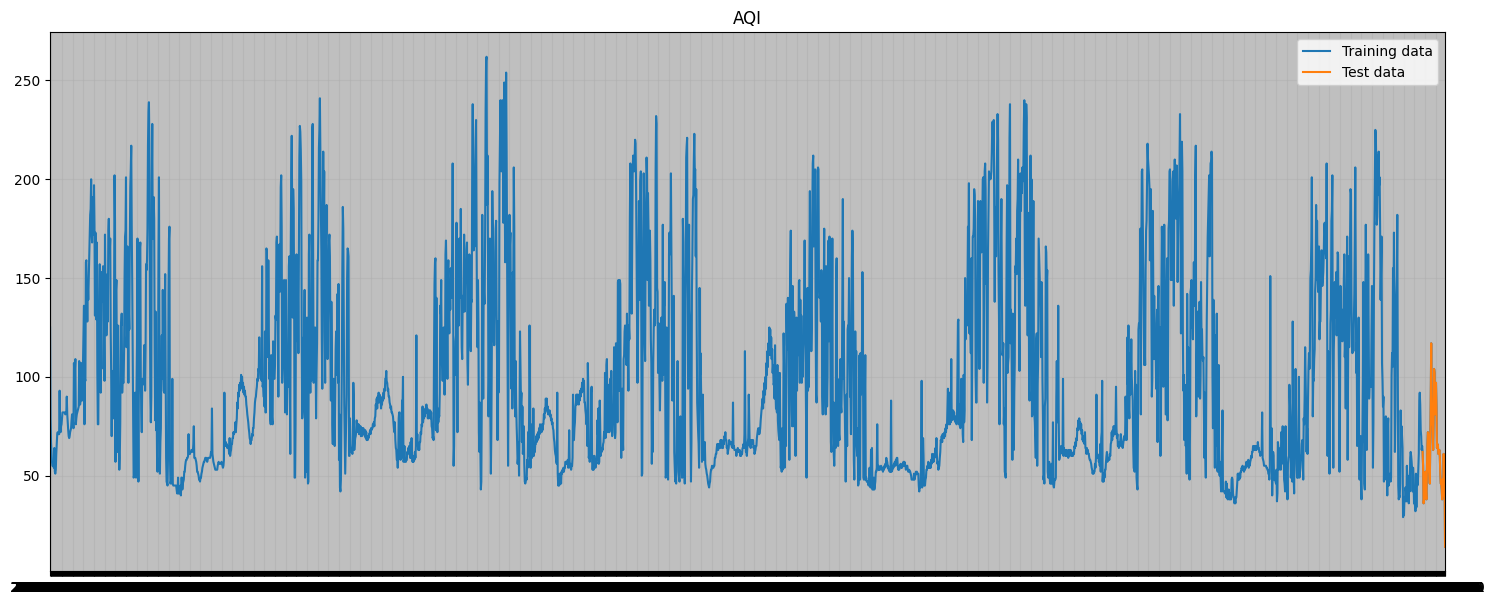

In [2]:
# Импортируем банные
data = pd.read_csv("https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/Checkpoint4/ts_air_quality_index_2013_2020.csv")
data = data[["aqi", "Date"]]
df = data.set_index("Date").sort_index()

# Разбиваем на трейн тест
df_train = df.iloc[:-48]
df_test = df.iloc[-48:]

# Рисуем
plt.figure(figsize=(18, 7))
plt.plot(df, label="Training data")
plt.plot(df_test, label="Test data")
plt.grid(alpha=0.5)
plt.margins(x=0)
plt.legend()
plt.title("AQI")

### Получаем прогнозы на случайном дереве 

## Порядок следующий:
    
    def fit():
    def sample_forecast():
        def perform_forecast():
        def retransform forecast():
        
        
  ###  def fit:
        
    1. Логарифмируем исходный временной ряд (тип для обеспечения нормального распрелделения)
    2. ИСпользуем shift()  чтобы созать массив данныз со скользящим окном  (зависит от n_lags)
    arrey[index lag-1 lag]
            1     Nan   15
            2      15   25
            3      25   35
            
    3. Добавляем в массив сдвиг по сезонной компоненте (неслабый сдвиг если допустим seasonal_differences = 365 or 182)
    4. Удаляем пустые строки
    5. Получаем x_train и y_train
    6. Обучаем 1000 деревьев
    
   ### def perform: (n_period=len(df_test)=48)
    Цикл 10000 раз по умолчанию 
    
        1. Формируем массивы из последнего числа x_train и y_train (там какой то мутный цикл со срезами)
        2. Конкантенируем массивы
        3. Цикл (число раз = df_test)
            -Выбирается случайное дерево
            -Делается предсказание на сконкантенируемом массиве
            -Добавялется в лист прогнозов
            len(list(forecast)) = 48
    В конце цикла forecast добавляется в samples 
        
        len(samples) = 10000
        samples = [[forecast1], [forecast2],....,forecast48]    (len(forecast) = 48)
        forecast1 = [0.26, 0.21, -0.018]     (из-за логарифмирования малые числа)
        
   ### def retransform forecast:
    1.Обратное преобрзование по сезону
    2.Обратное преобразование по шагу
    3.Обтратное логарифмирование
        
   #### Функция возвраoает массив: arrray[[17,16, 0.065].........]  len(array)= 10000
     
     
   ### На массиве полученном в def retransform_forecast получаем предсказания

# Ниже сам метод и эксперименты

In [2]:
class RandomForestARModel:
    """
    Метод для обучения случайного леса на временном ряду
    """

    def __init__(
        self,
        n_lags=1,
        max_depth=3,
        n_estimators=1000,
        random_state=123,
        log_transform=False,
        first_differences=False,
        seasonal_differences=None,
    ):
        """
        Аргументы:
        n_lags: количество объектов с задержкой, которые необходимо учитывать в авторегрессионной модели.
        max_depth: Максимальная глубина для деревьев регрессии леса
        random_state: случайное состояние для перехода в случайный лес

        log_transform: следует ли преобразовывать входные данные в журнал
        first_differences: должны ли входные данные отличаться по одному
        seasonal_differences: следует учитывать сезонность, если "Нет", то сезонность не предполагается
        """

        self.n_lags = n_lags
        self.model = RandomForestRegressor(
            max_depth=max_depth, n_estimators=n_estimators, random_state=random_state
        )

        self.log_transform = log_transform
        self.first_differences = first_differences
        self.seasonal_differences = seasonal_differences

    def fit(self, y):
        """
        Args:
            y: training data (numpy array or pandas series/dataframe)
        """
        # enable pandas functions via dataframes
        y_df = pd.DataFrame(y)
        self.y_df = deepcopy(y_df)

        # apply transformations and store results for retransformations
        if self.log_transform:
            y_df = np.log(y_df)
            self.y_logged = deepcopy(y_df)

        if self.first_differences:
            y_df = y_df.diff().dropna()
            self.y_diffed = deepcopy(y_df)

        if self.seasonal_differences is not None:
            y_df = y_df.diff(self.seasonal_differences).dropna()
            self.y_diffed_seasonal = deepcopy(y_df)

        # get lagged features
        Xtrain = pd.concat(
            [y_df.shift(t) for t in range(1, self.n_lags + 1)], axis=1
        ).dropna()
        self.Xtrain = Xtrain

        ytrain = y_df.loc[Xtrain.index, :]
        self.ytrain = ytrain

        self.model.fit(Xtrain.values, ytrain.values.reshape(-1))

    def sample_forecast(self, n_periods=1, n_samples=10000, random_seed=123):
        """
        Составьте прогнозные выборки путем случайного отбора со всех деревьев в лесу за прогнозируемый период
        Аргументы:
        n_periods: количество периодов для прогнозирования
        n_samples: количество образцов для рисования
        random_seed: Случайное начальное значение для numpy
        """
        samples = self._perform_forecast(n_periods, n_samples, random_seed)
        output = self._retransform_forecast(samples, n_periods)

        return output

    def _perform_forecast(self, n_periods, n_samples, random_seed):
        """
        Аргументы:
        n_periods: количество периодов для прогнозирования
        n_samples: количество образцов для рисования
        random_seed: Случайное начальное значение для numpy
        """
        samples = []

        np.random.seed(random_seed)
        for i in range(n_samples):
            # сохраняйте запаздывающей функции для каждого периода
            Xf = np.concatenate(
                [
                    self.Xtrain.iloc[-1, 1:].values.reshape(1, -1),
                    self.ytrain.iloc[-1].values.reshape(1, 1),
                ],
                1,
            )

            forecasts = []

            for t in range(n_periods):
                tree = self.model.estimators_[
                    np.random.randint(len(self.model.estimators_))
                ]
                pred = tree.predict(Xf)[0]
                forecasts.append(pred)

                # update lagged features for next period
                Xf = np.concatenate([Xf[:, 1:], np.array([[pred]])], 1)

            samples.append(forecasts)

        return samples

    def _retransform_forecast(self, samples, n_periods):
        """
        Прогноз повторного преобразования (повторная разница и возведение в степень)
        Аргументы:
        образцы: Прогнозные образцы для преобразования
        n_periods: количество периодов для прогнозирования
        """

        full_sample_tree = []

        for samp in samples:
            draw = np.array(samp)

            # retransform seasonal differencing
            if self.seasonal_differences is not None:
                result = list(self.y_diffed.iloc[-self.seasonal_differences :].values)
                for t in range(n_periods):
                    result.append(result[t] + draw[t])
                result = result[self.seasonal_differences :]
            else:
                result = []
                for t in range(n_periods):
                    result.append(draw[t])

            # retransform first differences
            y_for_add = (
                self.y_logged.values[-1] if self.log_transform else self.y_df.values[-1]
            )

            if self.first_differences:
                result = y_for_add + np.cumsum(result)

            # retransform log transformation
            if self.log_transform:
                result = np.exp(result)

            full_sample_tree.append(result.reshape(-1, 1))

        return np.concatenate(full_sample_tree, 1)

# Эксперименты с n_lags и сезонной компонентой

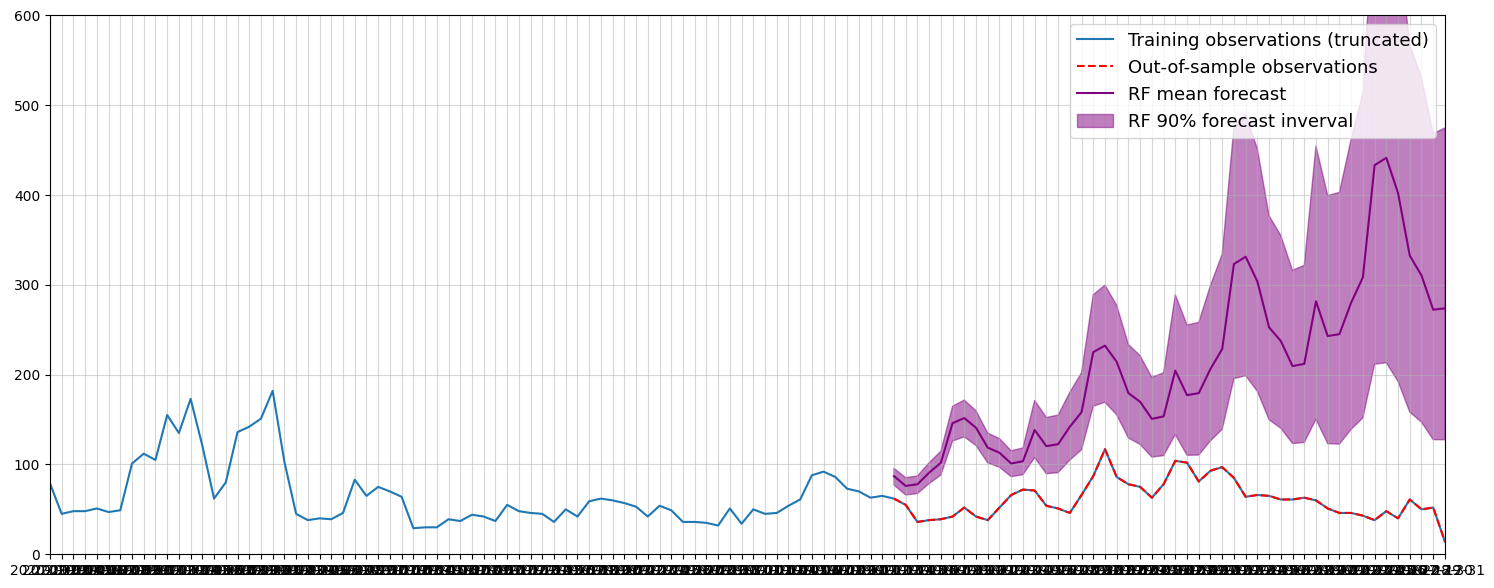

In [4]:
model = RandomForestARModel(n_lags=2, log_transform=True, first_differences=True, seasonal_differences=12)
model.fit(df_train)

predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)


means_forest = np.mean(predictions_forest, 1)
lowers_forest = np.quantile(predictions_forest, 0.05, 1)
uppers_forest = np.quantile(predictions_forest, 0.95, 1)

plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label="Training observations (truncated)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")

plt.plot(df_test.index, means_forest, color="purple", label="RF mean forecast")

plt.fill_between(
    df_test.index,
    lowers_forest,
    uppers_forest,
    color="purple",
    alpha=0.5,
    label="RF 90% forecast inverval",
)

plt.legend(fontsize=13)
plt.margins(x=0)

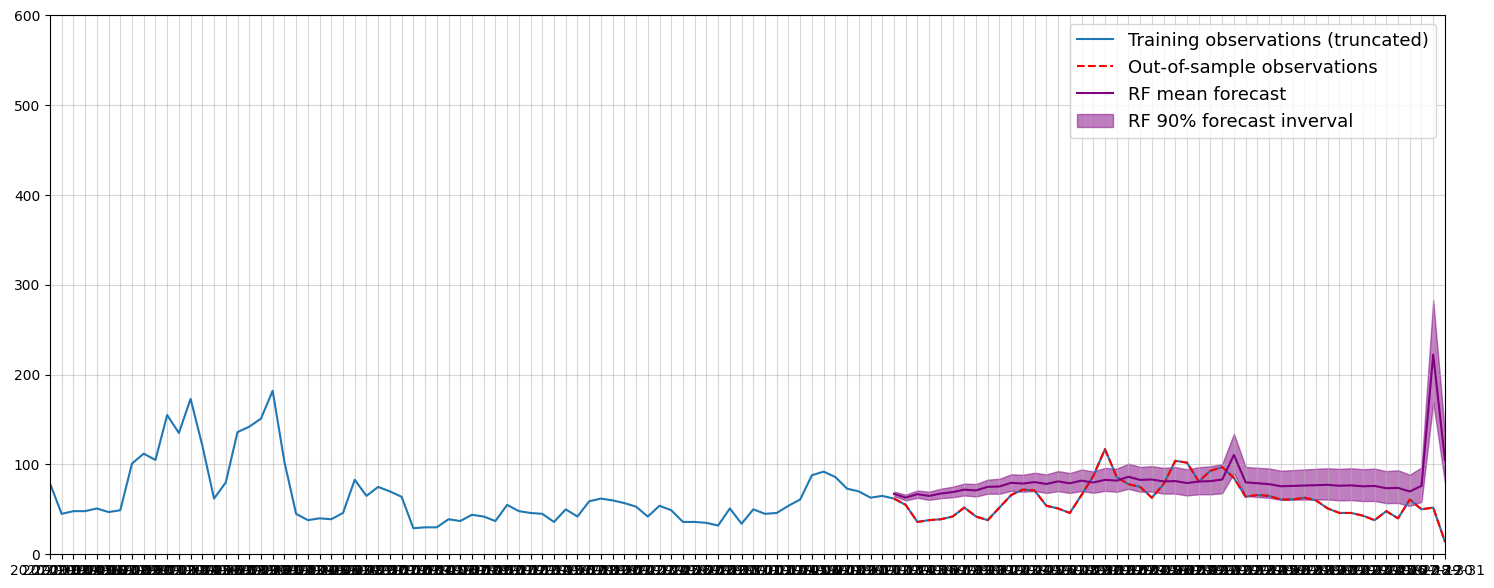

In [16]:
model = RandomForestARModel(n_lags=1, log_transform=True, first_differences=True, seasonal_differences=365)
model.fit(df_train)

predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)


means_forest = np.mean(predictions_forest, 1)
lowers_forest = np.quantile(predictions_forest, 0.05, 1)
uppers_forest = np.quantile(predictions_forest, 0.95, 1)

plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label="Training observations (truncated)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")

plt.plot(df_test.index, means_forest, color="purple", label="RF mean forecast")

plt.fill_between(
    df_test.index,
    lowers_forest,
    uppers_forest,
    color="purple",
    alpha=0.5,
    label="RF 90% forecast inverval",
)

plt.legend(fontsize=13)
plt.margins(x=0)

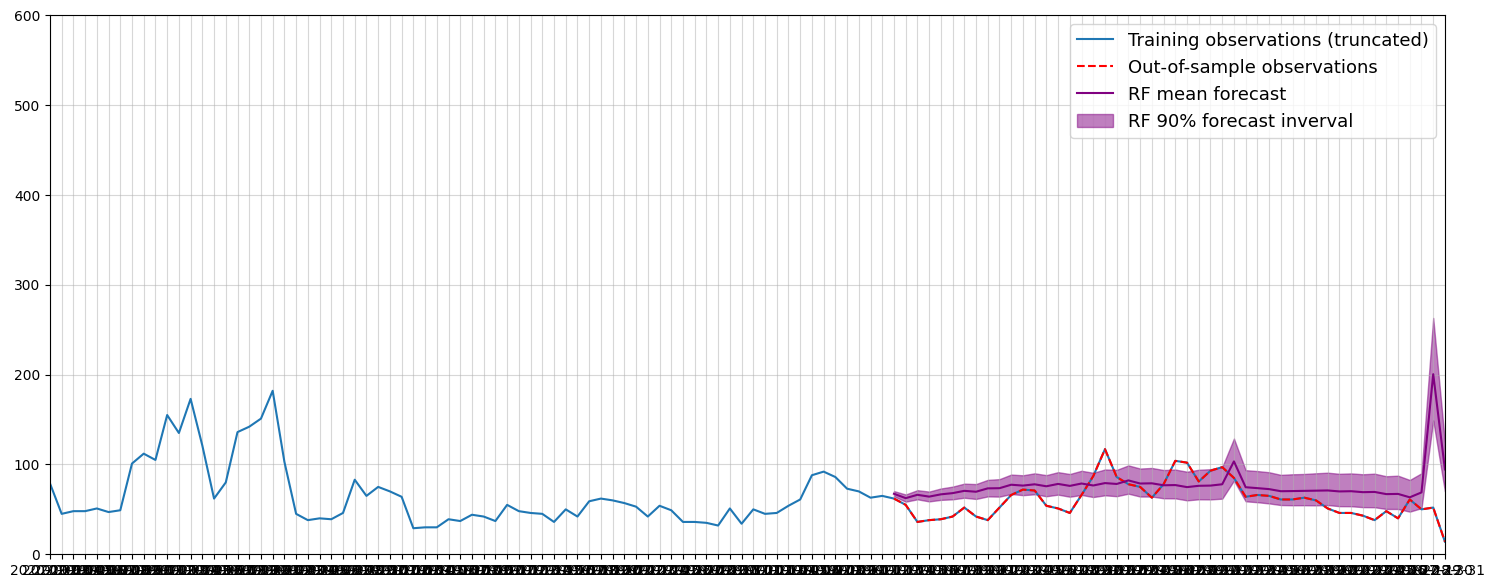

In [17]:
model = RandomForestARModel(n_lags=2, log_transform=True, first_differences=True, seasonal_differences=365)
model.fit(df_train)

predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)


means_forest = np.mean(predictions_forest, 1)
lowers_forest = np.quantile(predictions_forest, 0.05, 1)
uppers_forest = np.quantile(predictions_forest, 0.95, 1)

plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label="Training observations (truncated)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")

plt.plot(df_test.index, means_forest, color="purple", label="RF mean forecast")

plt.fill_between(
    df_test.index,
    lowers_forest,
    uppers_forest,
    color="purple",
    alpha=0.5,
    label="RF 90% forecast inverval",
)

plt.legend(fontsize=13)
plt.margins(x=0)

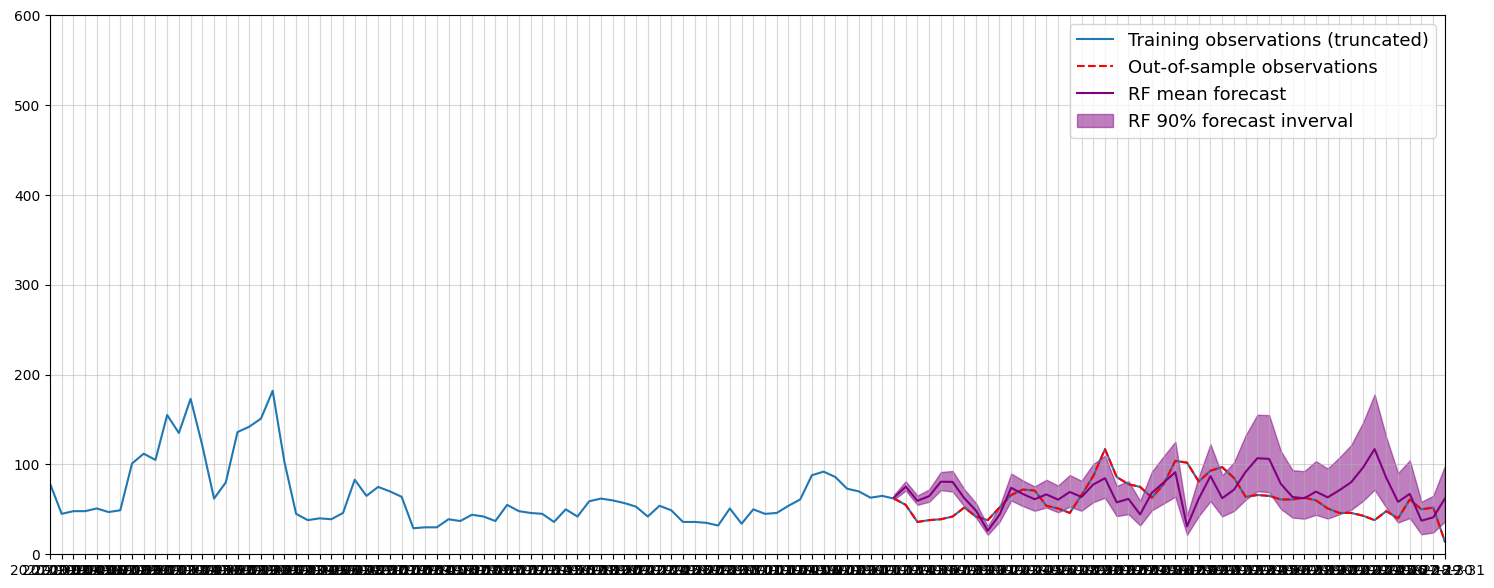

In [18]:
model = RandomForestARModel(n_lags=1, log_transform=True, first_differences=True, seasonal_differences=182)
model.fit(df_train)

predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)


means_forest = np.mean(predictions_forest, 1)
lowers_forest = np.quantile(predictions_forest, 0.05, 1)
uppers_forest = np.quantile(predictions_forest, 0.95, 1)

plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label="Training observations (truncated)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")

plt.plot(df_test.index, means_forest, color="purple", label="RF mean forecast")

plt.fill_between(
    df_test.index,
    lowers_forest,
    uppers_forest,
    color="purple",
    alpha=0.5,
    label="RF 90% forecast inverval",
)

plt.legend(fontsize=13)
plt.margins(x=0)

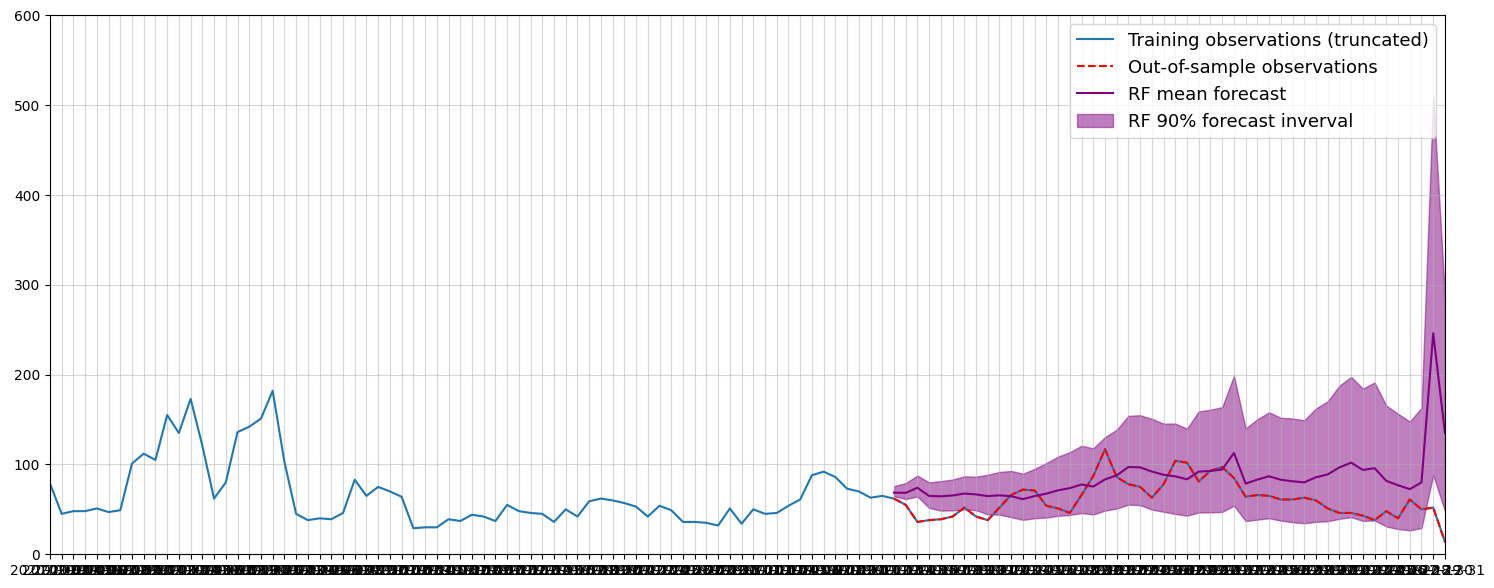

In [22]:
model = RandomForestARModel(n_lags=60, log_transform=True, first_differences=True, seasonal_differences=365)
model.fit(df_train)

predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)


means_forest = np.mean(predictions_forest, 1)
lowers_forest = np.quantile(predictions_forest, 0.05, 1)
uppers_forest = np.quantile(predictions_forest, 0.95, 1)

plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label="Training observations (truncated)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")

plt.plot(df_test.index, means_forest, color="purple", label="RF mean forecast")

plt.fill_between(
    df_test.index,
    lowers_forest,
    uppers_forest,
    color="purple",
    alpha=0.5,
    label="RF 90% forecast inverval",
)

plt.legend(fontsize=13)
plt.margins(x=0)

# Тут считал MAE для какого-то из экспериментов, чтобы сравнить с другом методом

In [13]:
prediction_forest1 = []
for i in predictions_forest:
    prediction_forest1.append(i[-1])

In [18]:
mean_absolute_error(df_test, prediction_forest1)

42.63275925560735